# Introdução

Dados desbalanceados são comumente encontrados nas aplicaçõs do aprendizado de máquina. Em problemas de classificação binária, o desbalanceamento se refere a uma predominância de amostras pertencentes a uma das classes. 

Na quiminformática, a classe majoritária é geralmente 0 (ausência de atividade, toxicidade, etc), em especial, quando os dados são resultantes de ensaios do tipo *high throughtput screening*, em que milhares de compostos são avaliados contra um alvo de interesse, com a expectativa de que uma pequena quantidade apresente alguma atividade. Note que quando usamos dados coletados da literatura, como do ChEMBL, o oposto pode ocorrer, pois os artigos científicos tendem a destacar os compostos ativos contra os alvos de interesse. Neste caso, o uso de *decoys* pode ser uma solução para balancear os dados.

Voltando ao exemplo de dados com predominância da classe 0: ao treinar um modelo de aprendizado de máquina, o algoritmo naturalmente terá uma alta tendência a prever a maioria dos compostos futuros como inativos, refletindo a probabilidade aprendida com o conjunto de treinamento. Como consequência, a quantidade de falsos negativos tende a ser alta, prejudicando a identificação de novos compostos ativos.

O artigo [GHOST: Adjusting the Decision Threshold to Handle Imbalanced Data in Machine Learning](https://pubs.acs.org/doi/full/10.1021/acs.jcim.1c00160) discute algumas dessas questões, e propõe abordagens para lidar com dados desbalanceados, por exemplo, considerar métricas diferentes da acurácia, como **Kappa de Cohen** e **Matthew's Correlation Coefficient** (MCC).

Todavia, a principal sugestão dos autores envolve modificar o valor de corte (*threshold*) dos modelos de classificação. Isso porque a maioria dos modelos de classificação fornece como predicão um valor entre 0 e 1, que é posteriormente convertido a uma das classes. O valor de corte padrão dos modelos é 0.5, ou seja, predições maiores que 0.5 são classificadas como pertencentes à classe 1, e as menores, à classe 0. Em alguns casos, essas predições podem ser interpretadas como probabilidades. Para mais detalhes, veja os Notebooks sobre Calibração de modelos.

Vamos mostrar na prática como isso funciona, usando o conjunto de dados CHEMBL1614421:

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../datasets/CHEMBL1614421.csv", dtype={3: 'str'}, sep=";")
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL1440854,NaN,None,409.49,0,4.25,SID24273973,COc1ccc(NC(=O)C(Cc2c[nH]c3ccccc23)NC(=O)OC(C)(...,Potency,'=',...,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN,NaN,NaN
1,CHEMBL1558466,NaN,None,305.34,0,2.18,SID859875,Cn1c(=O)c2cn(-c3cccc4ccccc34)cc2n(C)c1=O,Potency,'=',...,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN,NaN,NaN
2,CHEMBL1501307,NaN,None,368.43,0,1.55,SID24787413,O=C1c2ccccc2C(=O)c2c(NCCCN(CCO)CCO)cccc21,Potency,'=',...,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN,NaN,NaN
3,CHEMBL1557023,NaN,None,361.38,0,0.44,SID22401770,COc1cc(OC)cc(C(=O)NC(=S)NNC(=O)c2cnccn2)c1,Potency,'=',...,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN,NaN,NaN
4,CHEMBL1721937,NaN,None,420.90,1,6.05,SID17507706,Oc1ccc(N=Nc2cccc(Cl)c2)cc1/C=N/c1ccc(N2CCOCC2)cc1,Potency,'=',...,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN,NaN,NaN


In [3]:
df = df[df["Smiles"].notna()].copy()
df.shape

(49752, 47)

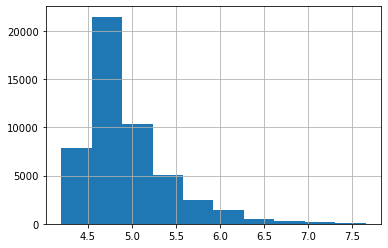

In [4]:
df['pChEMBL Value'].hist();

In [5]:
# Criamos uma coluna com valores binários com base no pChEMBL value
# Maior que 6.0 = ativo, menor que 5.0 = inativo
df['Active'] = df['pChEMBL Value'].apply(lambda x: 1 if x > 6.0 else (0 if x < 5.0 else None))
df = df.dropna(subset=['Active'])
df["Active"].value_counts()

0.0    34067
1.0     1945
Name: Active, dtype: int64

Vamos determinar o desbalanceamento do conjunto de dados calculando a *imbalance ratio (IR)*: a razão entre a quantidade de amostras na classe majoritária dividida pela quantidade de amostras na classe minoritária

In [6]:
import pandas as pd

def imbalance_ratio(binary_col):
    """
    Calcula a razão do número de amostras na classe majoritária
    para o número de amostras na classe minoritária para uma coluna com 0s e 1s.

    Parâmetros:
        binary_col (pd.Series): Uma série Pandas contendo 0s e 1s.
    """
    if not set(binary_col).issubset({0, 1}):
        raise ValueError("A coluna deve conter apenas 0s e 1s.")

    class_counts = binary_col.value_counts()
    majority_class = class_counts.idxmax()
    majority_count = class_counts.max()
    minority_count = class_counts.min()

    imbalance_ratio = majority_count / minority_count
    
    print(f"Classe majoritária: {majority_class}")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")

In [7]:
imbalance_ratio(df["Active"])

Classe majoritária: 0.0
Imbalance ratio: 17.52


Há 17 vezes mais inativos do que ativos neste conjunto de dados.

Podemos agora treinar um modelo de classificação *Random Forest* baseado em *fingerprints Morgan*:

In [8]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator

# Cálculo dos Morgan fingerprints

# Gerador de fingerprints
mfpgen = rdFingerprintGenerator.GetMorganGenerator(fpSize=512)

# Adicionar coluna RDKit Mol ao DataFrame
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='Smiles', molCol='Mol')

# Gerar fingerprints no formato numpy array
fps = [mfpgen.GetFingerprintAsNumPy(mol) for mol in df['Mol']]

# Converter a um pandas DataFrame
fps = pd.DataFrame(fps, columns=[str(i) for i in range(len(fps[0]))])

[16:44:21] WARNING: not removing hydrogen atom without neighbors


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# Separar conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(fps, df['Active'], stratify=df['Active'], random_state=0)

# Isso evita um erro ao chamar a função confusion_matrix()
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
# Função para cálculo de métricas dos modelos
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef, roc_auc_score

def evaluate_classification_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'cohen_kappa': cohen_kappa_score(y_test, y_pred),
        'mcc': matthews_corrcoef(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred, labels=[0, 1])
    }

    return metrics


## Modelo de classificação com valor de corte padrão = 0.5

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [12]:
metrics_threshold_05 = evaluate_classification_model(rf, X_train, X_test, y_train, y_test)

In [13]:
print("Acurácia:", metrics_threshold_05['accuracy'])
print("Kappa de Cohen:", metrics_threshold_05['cohen_kappa'])
print("MCC:", metrics_threshold_05['mcc'])
print("ROC/AUC:", metrics_threshold_05['roc_auc'])

Acurácia: 0.9520159946684439
Kappa de Cohen: 0.22739451728247917
MCC: 0.328918310334238
ROC/AUC: 0.7776229192546883


Conforme esperado, o modelo apresenta acurácia muito alta, mas isso não reflete um modelo com alta capacidade preditiva. Vejamos a matriz de confusão, que classifica as predições feitas pelo modelo como verdadeiros positivos, falsos positivos, falsos negativos e verdadeiros negativos:

In [14]:
cm = metrics_threshold_05['confusion_matrix']
cm

array([[8503,   14],
       [ 418,   68]], dtype=int64)

Note que a maioria dos compostos do conjunto de teste são preditos como pertencentes à classe 0. Portanto, a métrica acurácia não é confiável nesse caso. Isso pode ser confirmado pelas outras métricas calculadas, que variam de -1 a 1 no caso do Kappa de Cohen, e de 0 a 1 no caso do MCC (quanto mais próximo de 1, melhor é o modelo).

Note, porém, que a métrica ROC/AUC tem um valor razoável, indicando que o modelo tem uma razoável capacidade de distinguir ativos de inativos. Vamos ver o que acontece ao modificarmos o *threshold* de classificação para um valor menor. Uma forma de fazer isso é criando uma nova classe do Python a partir da função `RandomForestClassifier`.

## Modelo com valor de corte (*threshold*) ajustável

In [15]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

class CustomThresholdRandomForest(RandomForestClassifier):
    def __init__(self, threshold, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    # Definimos uma nova função predict()
    def predict(self, X):
        # Probabilidades
        y_prob = self.predict_proba(X)

        # Aplicamos o threshold desejado
        predictions = (y_prob[:, 1] >= self.threshold).astype(int)

        return np.array(predictions)


Vamos explorar alguns valores de corte. Repetimos o valor 0.5 para comparação.

In [16]:
for thr in [0.5, 0.2, 0.1]:
    print(f"Modelo com valor de corte igual a {thr}")
    threshold_model = CustomThresholdRandomForest(threshold=thr)
    metrics_threshold = evaluate_classification_model(threshold_model, X_train, X_test, y_train, y_test)
    print("Acurácia:", metrics_threshold['accuracy'])
    print("Kappa de Cohen:", metrics_threshold['cohen_kappa'])
    print("MCC:", metrics_threshold['mcc'])
    print("ROC/AUC:", metrics_threshold['roc_auc'])
    print("Matriz de confusão")
    print(metrics_threshold['confusion_matrix'])
    print()

Modelo com valor de corte igual a 0.5
Acurácia: 0.951682772409197
Kappa de Cohen: 0.22078608125119759
MCC: 0.32079413823261116
ROC/AUC: 0.7750960195319841
Matriz de confusão
[[8502   15]
 [ 420   66]]

Modelo com valor de corte igual a 0.2
Acurácia: 0.9505720315450406
Kappa de Cohen: 0.41709918626226683
MCC: 0.42850948047600057
ROC/AUC: 0.7775544287846481
Matriz de confusão
[[8382  135]
 [ 310  176]]

Modelo com valor de corte igual a 0.1
Acurácia: 0.8860379873375541
Kappa de Cohen: 0.270571763618919
MCC: 0.2935937494206196
ROC/AUC: 0.7815405258232022
Matriz de confusão
[[7731  786]
 [ 240  246]]



Com a mudança do valor de corte de 0.5 para 0.2, mais amostras são classificadas como positivas, o que aumenta tanto o número de verdadeiros positivos quanto o de falsos positivos. Neste caso, isso melhorou os valores das métricas Kappa de Cohen e MCC, e a acurácia não diminuiu significativamente. Note que o valor de ROC/AUC se mantém aproximadamente constante, pois o modelo que treinamos é essencialmente o mesmo; apenas modificamos o valor de corte da classificação. Neste caso, podemos dizer que a mudança de *threshold* para 0.2 gerou um modelo de classificação melhor que o padrão.

## Considerações finais

Neste *Notebook* apresentamos de forma simplificada o conceito de mudança do valor de corte de um modelo de classificação. Ressaltamos que o código não está otimizado para encontrar o melhor valor de corte. A validade dessa estratégia também depende do quanto seu modelo é capaz de discriminar entre as classes: modelos com valores baixos de ROC/AUC não apresentarão melhor desempenho mudando o *threshold* de classificação. Para uma abordagem que otimiza o *threshold* de acordo com o melhor valor de Kappa de Cohen, veja repositório do método [GHOST](https://github.com/rinikerlab/GHOST/).